In [2]:
import pandas as pd
import feather
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Merge the outputs of the optimization model with the power plant characteristics

In [3]:
# Load optimization output
gen = feather.read_dataframe('../gen_v2')

In [4]:
# Compute yearly and quarterly generation
carac = pd.read_csv('../optimization_model/good_model_inputs/inputs_generators_v2.csv')
carac['generation'] = gen.sum(axis=1)
carac['generation Q1'] = gen.iloc[:,:2159].sum(axis=1)
carac['generation Q2'] = gen.iloc[:,2160:4344].sum(axis=1)
carac['generation Q3'] = gen.iloc[:,4345:6553].sum(axis=1)
carac['generation Q4'] = gen.iloc[:,6553:].sum(axis=1)
for i in range(1,5):
    carac[f'NOx Q{i}'] = carac[f'generation Q{i}'] * carac['PLNOXRTA'] * 0.45359 # 0.45 kg / lb
    carac[f'SO2 Q{i}'] = carac[f'generation Q{i}'] * carac['PLSO2RTA'] * 0.45359 # 0.45 kg / lb
    carac[f'CO2 Q{i}'] = carac[f'generation Q{i}'] * carac['generationCO2'] * 1e3 # kWh / MWh (generation CO2 seems to be in kg/kWh)

carac['capafac'] = carac['generation'] / (8759 * carac['Capacity'])
#carac.to_csv('./outputs/annual_gen_mod.csv')

## Get NEI data

In [7]:
# one csv per state per quarter
files = !../NEI_gc_vs_model/gaftp.epa.gov/2016/DLY*.csv*



In [8]:
# convert us names to abbreviations
us_state_abbrev={'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',\
                'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia':\
                'DC','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho':\
                'ID','Illinois': 'IL','Indiana': 'IN','Iowa':'IA','Kansas': 'KS','Kentucky': 'KY',\
                'Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA',\
                'Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO',\
                'Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH',\
                 'New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC',\
                 'North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH','Oklahoma': 'OK',\
                 'Oregon': 'OR','Palau': 'PW','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI',\
                 'South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT',\
                 'Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia':\
                 'WV','Wisconsin': 'WI','Wyoming': 'WY'}

# thank you to @kinghelix and @trevormarburger for this idea
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

In [9]:
comparison_nox = pd.DataFrame(data=[], index = abbrev_us_state.keys(), columns=['me Q1', 'nei Q1', 'me Q2', 'nei Q2', 'me Q3', 'nei Q3', 'me Q4', 'nei Q4'])
comparison_so2 = pd.DataFrame(data=[], index = abbrev_us_state.keys(), columns=['me Q1', 'nei Q1', 'me Q2', 'nei Q2', 'me Q3', 'nei Q3', 'me Q4', 'nei Q4'])
comparison_co2 = pd.DataFrame(data=[], index = abbrev_us_state.keys(), columns=['me Q1', 'nei Q1', 'me Q2', 'nei Q2', 'me Q3', 'nei Q3', 'me Q4', 'nei Q4'])

In [10]:
# Loop through Lyssa's files and complete table accordingly
for file in files:
    state = file[-8:-6].upper()
    quarter = file[-6:-4]
    temp = pd.read_csv(file)
    comparison_nox.loc[state, f'nei {quarter}'] = temp['NOX_MASS (tons)'].sum() * 907.185 #kg / sort ton
    comparison_so2.loc[state, f'nei {quarter}'] = temp['SO2_MASS (tons)'].sum() * 907.185 #kg / sort ton
    comparison_co2.loc[state, f'nei {quarter}'] = temp['CO2_MASS (tons)'].sum() * 907.185 #kg / sort ton
    comparison_nox.loc[state, f'me {quarter}'] = carac.groupby('StateName')[f'NOx {quarter}'].sum().loc[abbrev_us_state[state]]
    comparison_so2.loc[state, f'me {quarter}'] = carac.groupby('StateName')[f'SO2 {quarter}'].sum().loc[abbrev_us_state[state]]
    comparison_co2.loc[state, f'me {quarter}'] = carac.groupby('StateName')[f'CO2 {quarter}'].sum().loc[abbrev_us_state[state]]
        

FileNotFoundError: [Errno 2] File b'/bin/bash: ../NEI_gc_vs_model/gaftp.epa.gov/2016/DLY_2016alQ1.csv: Permission denied' does not exist: b'/bin/bash: ../NEI_gc_vs_model/gaftp.epa.gov/2016/DLY_2016alQ1.csv: Permission denied'

In [9]:
for comp in [comparison_nox, comparison_so2, comparison_co2]:
    comp['me total'] = comp['me Q1'] + comp['me Q2'] + comp['me Q3'] + comp['me Q4']
    comp['nei total'] = comp['nei Q1'] + comp['nei Q2'] + comp['nei Q3'] + comp['nei Q4']

<IPython.core.display.Javascript object>


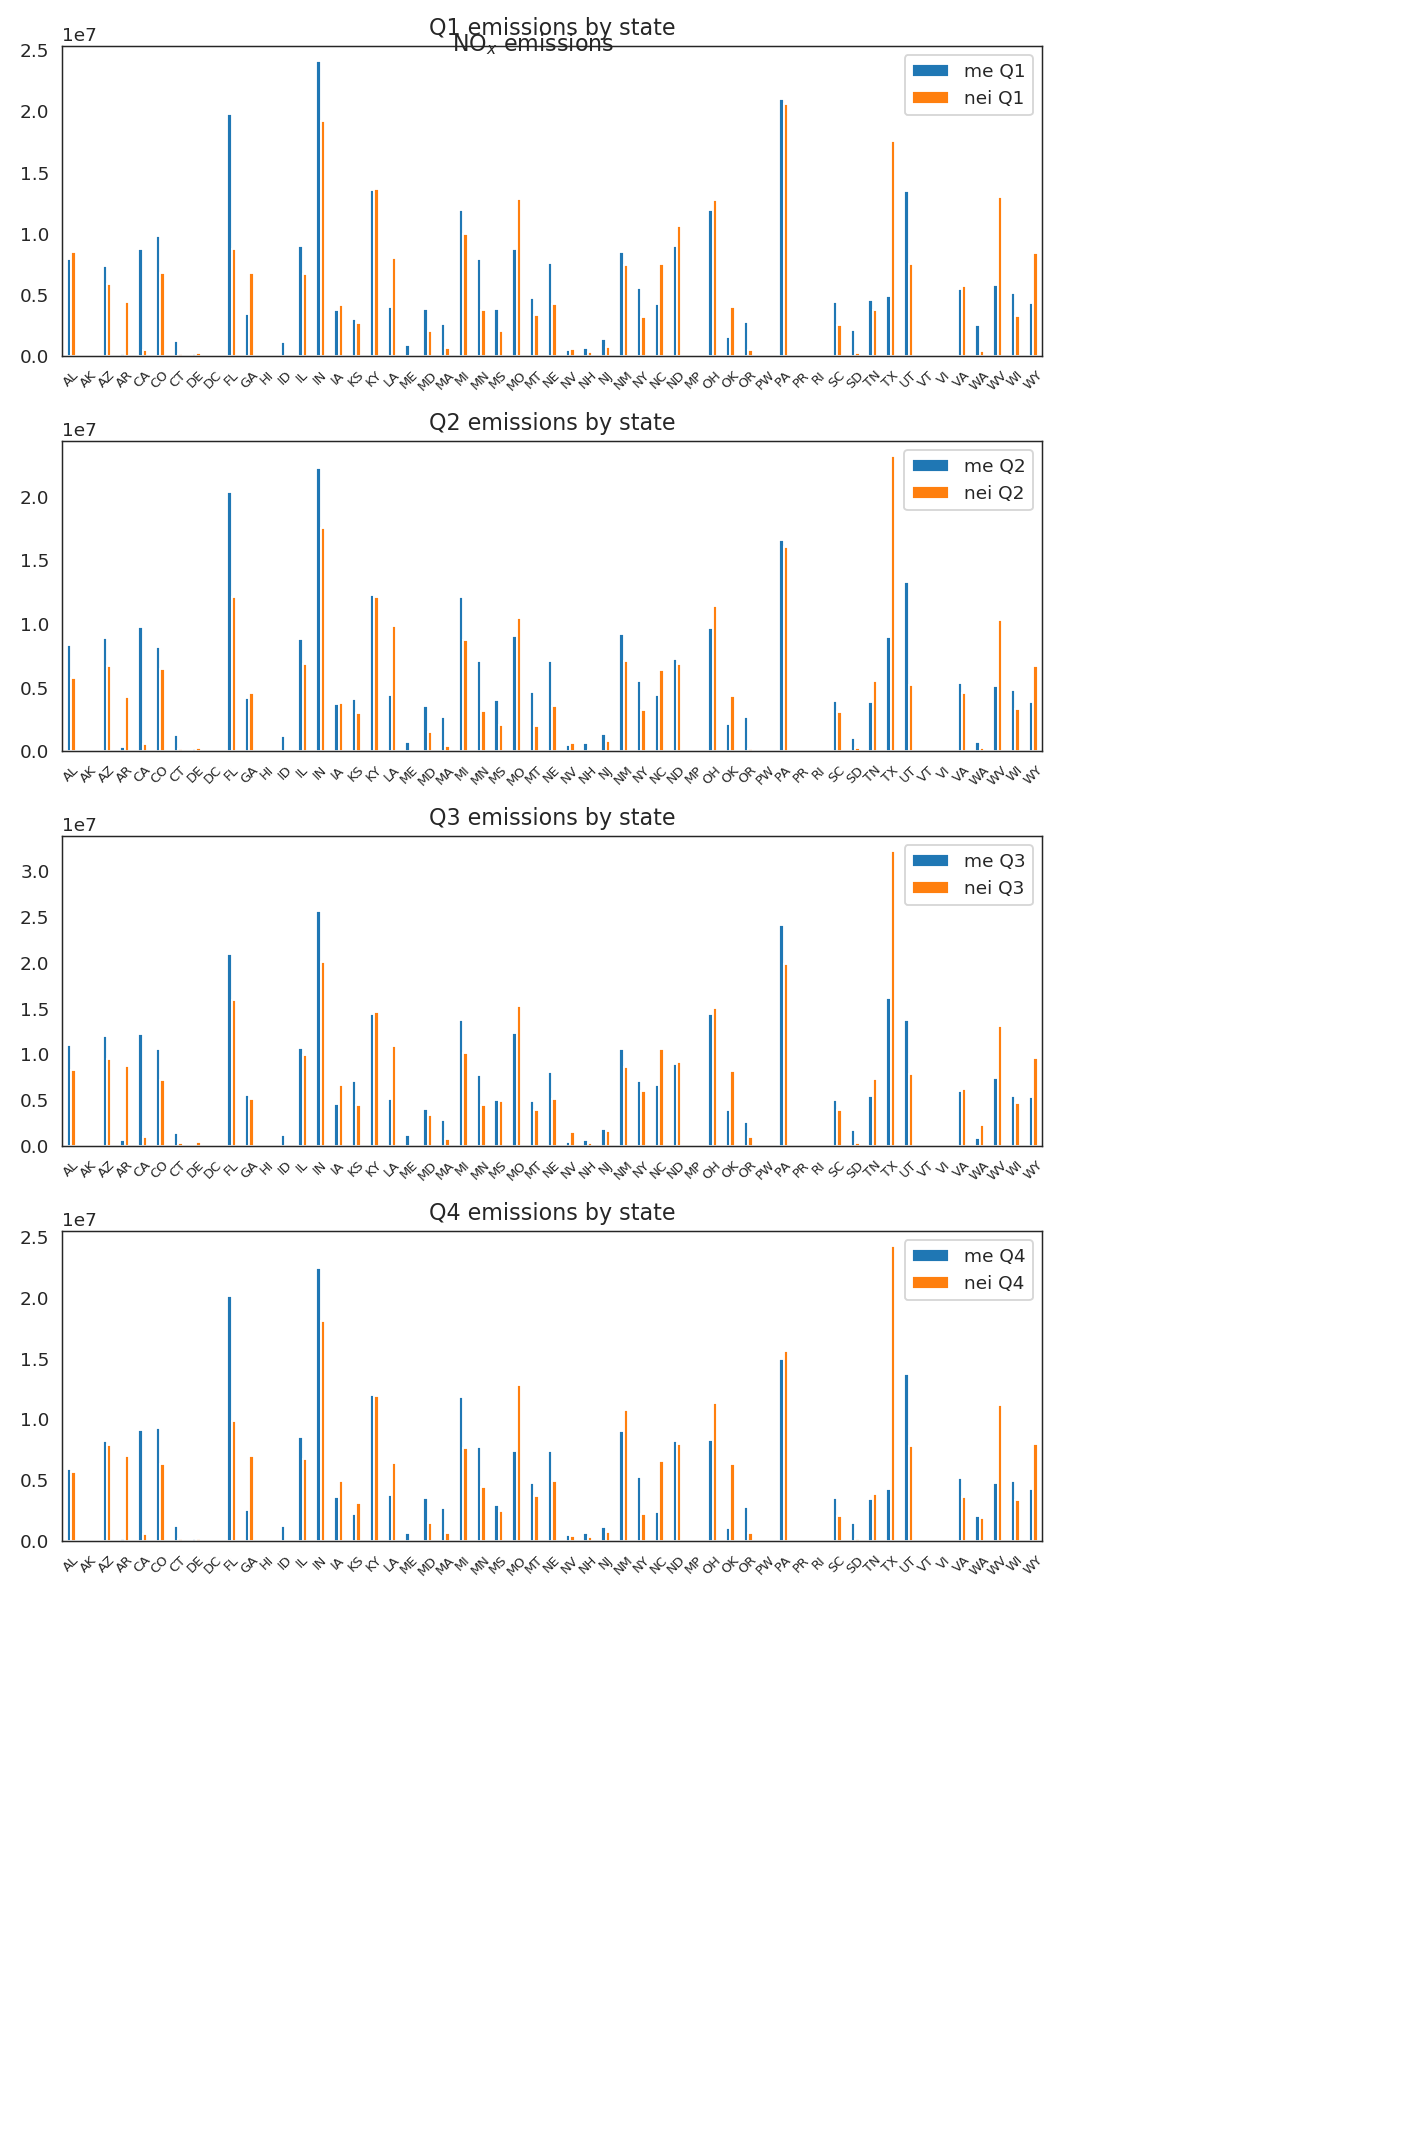

In [8]:
%matplotlib notebook
sns.set_style('white')
fig, axes = plt.subplots(4,1,figsize=(8,12))
comp = comparison_nox
fig.suptitle('NO$_x$ emissions')
comp[['me Q1', 'nei Q1']].plot.bar(ax=axes[0])
comp[['me Q2', 'nei Q2']].plot.bar(ax=axes[1])
comp[['me Q3', 'nei Q3']].plot.bar(ax=axes[2])
comp[['me Q4', 'nei Q4']].plot.bar(ax=axes[3])
axes[0].set_title('Q1 emissions by state')
axes[1].set_title('Q2 emissions by state')
axes[2].set_title('Q3 emissions by state')
axes[3].set_title('Q4 emissions by state')
kw = {'rotation': 45, 'fontsize': 7}
for ax in axes.reshape(-1):
    ax.set_xticklabels(ax.get_xticklabels(), **kw)
fig.tight_layout()
#plt.savefig('nox_comp.png', dpi=300)

In [ ]:
%matplotlib notebook
fig, axes = plt.subplots(4,1,figsize=(8,12))
comp = comparison_so2
fig.suptitle('SO2 emissions')
comp[['me Q1', 'nei Q1']].plot.bar(ax=axes[0])
comp[['me Q2', 'nei Q2']].plot.bar(ax=axes[1])
comp[['me Q3', 'nei Q3']].plot.bar(ax=axes[2])
comp[['me Q4', 'nei Q4']].plot.bar(ax=axes[3])
axes[0].set_title('Q1 emissions by state')
axes[1].set_title('Q2 emissions by state')
axes[2].set_title('Q3 emissions by state')
axes[3].set_title('Q4 emissions by state')
kw = {'rotation': 45}
for ax in axes.reshape(-1):
    ax.set_xticklabels(ax.get_xticklabels(), **kw)
fig.tight_layout()
#plt.savefig('so2_comp.png', dpi=300)

In [ ]:
%matplotlib notebook
fig, axes = plt.subplots(4,1,figsize=(8,12))
comp = comparison_co2
fig.suptitle('CO2 emissions')
comp[['me Q1', 'nei Q1']].plot.bar(ax=axes[0])
comp[['me Q2', 'nei Q2']].plot.bar(ax=axes[1])
comp[['me Q3', 'nei Q3']].plot.bar(ax=axes[2])
comp[['me Q4', 'nei Q4']].plot.bar(ax=axes[3])
axes[0].set_title('Q1 emissions by state')
axes[1].set_title('Q2 emissions by state')
axes[2].set_title('Q3 emissions by state')
axes[3].set_title('Q4 emissions by state')
kw = {'rotation': 45}
for ax in axes.reshape(-1):
    ax.set_xticklabels(ax.get_xticklabels(), **kw)
fig.tight_layout()
#plt.savefig('co2_comp.png', dpi=300)

In [16]:
comparison = pd.DataFrame(data=[], index=['nox', 'so2', 'co2'], columns=['Our model', 'NEI'])
comparison.loc['nox', 'Our model'] = comparison_nox[[f'me Q{i}' for i in range(1,5)]].dropna().sum().sum()
comparison.loc['nox', 'NEI'] = comparison_nox[[f'nei Q{i}' for i in range(1,5)]].dropna().sum().sum()
comparison.loc['so2', 'Our model'] = comparison_so2[[f'me Q{i}' for i in range(1,5)]].dropna().sum().sum()
comparison.loc['so2', 'NEI'] = comparison_so2[[f'nei Q{i}' for i in range(1,5)]].dropna().sum().sum()
comparison.loc['co2', 'Our model'] = comparison_co2[[f'me Q{i}' for i in range(1,5)]].dropna().sum().sum()*1e-3
comparison.loc['co2', 'NEI'] = comparison_co2[[f'nei Q{i}' for i in range(1,5)]].dropna().sum().sum()*1e-3
comparison['percent'] = 100*(comparison['Our model'] - comparison['NEI']) / comparison['NEI']

In [18]:
comparison

,Our model,NEI,percent
nox,1.1849e+09,1.11916e+09,5.87419
so2,1.70462e+09,1.35234e+09,26.0501
co2,1.72914e+09,1.81118e+09,-4.52968


## Compare annual total by state

<IPython.core.display.Javascript object>


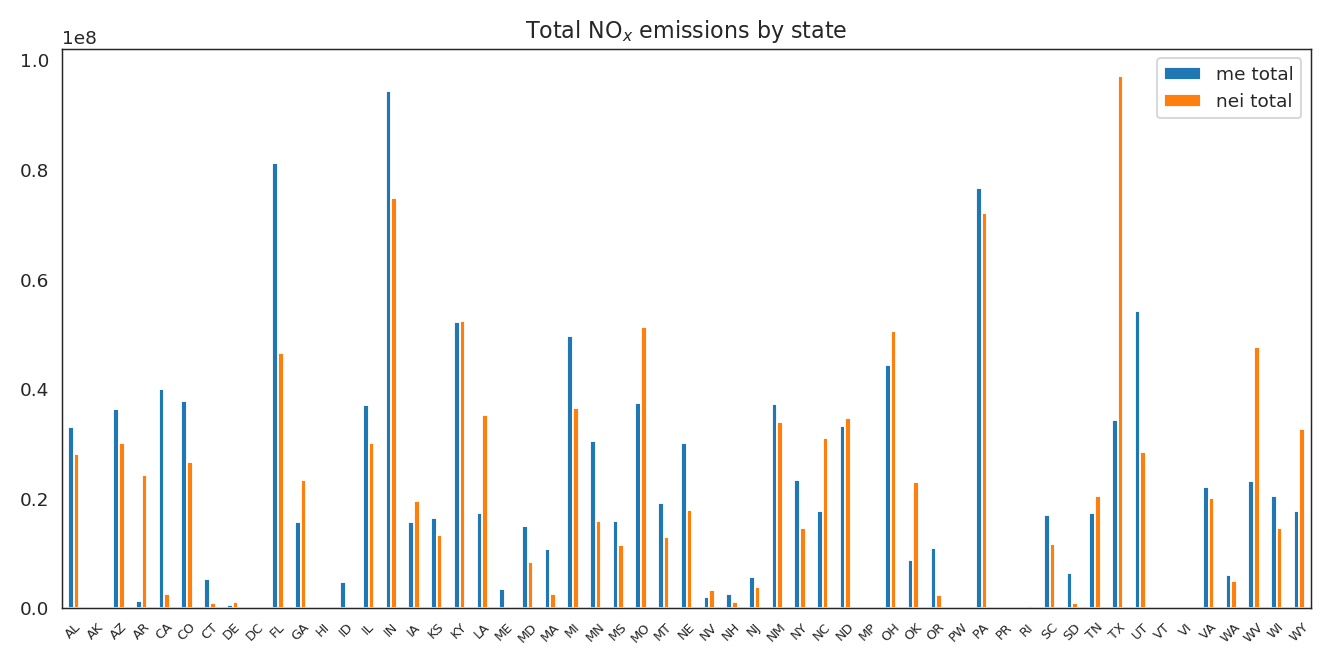

In [14]:
%matplotlib notebook
sns.set_style('white')
fig, axes = plt.subplots(1,1,figsize=(10,5))
comp = comparison_nox
#fig.suptitle('NO$_x$ emissions')
comp[['me total', 'nei total']].plot.bar(ax=axes)
axes.set_title('Total NO$_x$ emissions by state')
#axes.set_title('Total SO$_2$ emissions by state')
#axes.set_title('Total CO$_2$ emissions by state')
kw = {'rotation': 45, 'fontsize': 7}
axes.set_xticklabels(ax.get_xticklabels(), **kw)
fig.tight_layout()

In [ ]:
%matplotlib notebook
sns.set_style('white')
fig, ax = plt.subplots()
comparison[['Our model', 'NEI']].plot.bar(ax=ax)
ax.set_ylabel('Emissions (see x-axis for units)')
kw = {'rotation': 'horizontal'}
ax.set_xticklabels(['NO$_x$ (kg)', 'SO$_2$ (kg)', 'CO$_2$ (Mg)'], **kw)
fig.tight_layout()
#plt.savefig('compare_em.png', dpi=300)